In [61]:
import pandas as pd
from keras import models, layers, optimizers, regularizers
import numpy as np
import random
from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import datetime

In [62]:
train_data = pd.read_csv("02012009_29122017.csv")
test_data = pd.read_csv("02012018_31122018.csv")
train_data.head(5)
test_data.head(5)

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2018,2683.73,2695.81,2695.89,2682.36,1846463232
1,03-Jan-2018,2697.85,2713.06,2714.37,2697.77,2090595328
2,04-Jan-2018,2719.31,2723.99,2729.29,2719.07,2100767744
3,05-Jan-2018,2731.33,2743.15,2743.45,2727.92,1918869120
4,08-Jan-2018,2742.67,2747.71,2748.51,2737.60,1894823936


In [63]:
train_mask = train_data['Open Price']>train_data['Close Price']
test_mask = test_data['Open Price']>test_data['Close Price']

train_data.insert(6,'movement',1)
test_data.insert(6,'movement',1)

train_data.loc[train_mask, 'movement']=0
test_data.loc[test_mask, 'movement']=0

train_data['Date'] = train_data['Date'].map(lambda x:time.mktime(datetime.datetime.strptime(x, "%d-%b-%Y").timetuple()))
test_data['Date'] = test_data['Date'].map(lambda x:time.mktime(datetime.datetime.strptime(x, "%d-%b-%Y").timetuple()))

train_data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,movement
0,1.230826e+09,902.99,931.80,934.73,899.35,4048270080,1
1,1.231085e+09,929.17,927.45,936.63,919.53,5413910016,0
2,1.231171e+09,931.17,934.70,943.85,927.28,5392620032,1
3,1.231258e+09,927.45,906.65,927.45,902.37,4704940032,0
4,1.231344e+09,905.73,909.73,910.00,896.81,4991549952,1


In [64]:
x_train = train_data.loc[:, train_data.columns != 'movement']
y_train = train_data[['movement']]
x_test = test_data.loc[:, test_data.columns != 'movement']
y_test = test_data[['movement']]
x_test.head(5)

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,1.514822e+09,2683.73,2695.81,2695.89,2682.36,1846463232
1,1.514909e+09,2697.85,2713.06,2714.37,2697.77,2090595328
2,1.514995e+09,2719.31,2723.99,2729.29,2719.07,2100767744
3,1.515082e+09,2731.33,2743.15,2743.45,2727.92,1918869120
4,1.515341e+09,2742.67,2747.71,2748.51,2737.60,1894823936


In [65]:
cnt_1 = y_train[y_train['movement']==1].count()
cnt_0 = y_train[y_train['movement']==0].count()

In [66]:
x_train = preprocessing.normalize(x_train)
x_test = preprocessing.normalize(x_test)

In [67]:
hidden_units = 10    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 20          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

In [68]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=6,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [69]:
class_weight = {
    0: 1.,
    1: cnt_0 / cnt_1
}

Epoch 1/6
2264/2264 [==============================] - ETA: 27s - loss: 0.6274 - acc: 0.50 - ETA: 0s - loss: 0.6333 - acc: 0.5068 - 0s 221us/step - loss: 0.6328 - acc: 0.5110
Epoch 2/6
2264/2264 [==============================] - ETA: 1s - loss: 0.5992 - acc: 0.656 - ETA: 0s - loss: 0.6274 - acc: 0.547 - ETA: 0s - loss: 0.6282 - acc: 0.521 - 0s 76us/step - loss: 0.6294 - acc: 0.5075
Epoch 3/6
2264/2264 [==============================] - ETA: 0s - loss: 0.6346 - acc: 0.343 - ETA: 0s - loss: 0.6323 - acc: 0.479 - ETA: 0s - loss: 0.6316 - acc: 0.494 - ETA: 0s - loss: 0.6300 - acc: 0.506 - 0s 90us/step - loss: 0.6319 - acc: 0.5022
Epoch 4/6
2264/2264 [==============================] - ETA: 0s - loss: 0.6337 - acc: 0.500 - ETA: 0s - loss: 0.6337 - acc: 0.464 - ETA: 0s - loss: 0.6319 - acc: 0.500 - 0s 69us/step - loss: 0.6314 - acc: 0.4987
Epoch 5/6
2264/2264 [==============================] - ETA: 1s - loss: 0.6038 - acc: 0.656 - ETA: 0s - loss: 0.6318 - acc: 0.491 - ETA: 0s - loss: 0.6287 

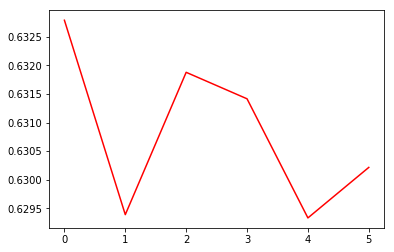

In [70]:
# train the parameters
history = model.fit(x_train, y_train, epochs=6, batch_size=batch_size, class_weight=class_weight)

# evaluate accuracy
train_acc = model.evaluate(x_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [71]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=20):
    train_accs = []
    test_accs = []
    with tqdm(total=n) as progress_bar:
        for _ in range(n):
            model.fit(
                x_train, 
                y_train, 
                epochs=epochs, 
                batch_size=batch_size, 
                class_weight=class_weight, 
                verbose=False)
            train_accs.append(model.evaluate(x_train, y_train, batch_size=32, verbose=False)[1])
            test_accs.append(model.evaluate(x_test, y_test, batch_size=32, verbose=False)[1])
            progress_bar.update()
    print('Avgerage Training Accuracy: %s' % np.average(train_accs))
    print('Avgerage Testing Accuracy: %s' % np.average(test_accs))
    return train_accs, test_accs

In [72]:
_, test_accs = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.65s/it]


Avgerage Training Accuracy: 0.5139134277355965
Avgerage Testing Accuracy: 0.501190476474308


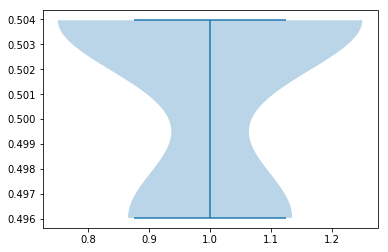

In [73]:
plt.violinplot(test_accs)
plt.show()

In [74]:
print('Min: %s' % np.min(test_accs))
print('Max: %s' % np.max(test_accs))

Min: 0.4960317450856406
Max: 0.5039682549143595


In [75]:
hidden_units = 6    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.              # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 50          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

In [76]:
def build_model(hidden_units, activation, learning_rate):
    model = models.Sequential()
    model.add(layers.Dense(input_dim=6,
                           units=hidden_units, 
                           activation=activation,
                           kernel_regularizer=regularizers.l2(l2)))
    model.add(layers.Dense(input_dim=hidden_units,
                           units=1,
                           activation='sigmoid',
                           kernel_regularizer=regularizers.l2(l2)))
    model.compile(loss='binary_crossentropy',
                  # Adam is a kind of gradient descent
                  optimizer=optimizers.Adam(lr=learning_rate),
                  metrics=['accuracy'])
    return model

model = build_model(hidden_units, activation, learning_rate)

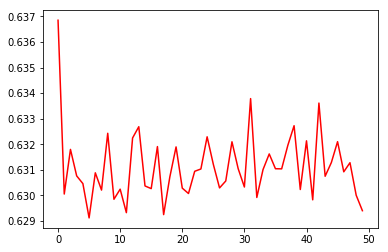

In [77]:
history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size, 
    class_weight=class_weight, verbose=False)
losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [78]:
_, __ = train_and_evaluate(model, x_train, y_train, x_test, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.13s/it]


Avgerage Training Accuracy: 0.4814487633877844
Avgerage Testing Accuracy: 0.49841269803425625
